<a href="https://colab.research.google.com/github/Yijing-Wen/CS827-DL_in_Visual_Computing/blob/main/Week_4-GAN/srgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip # This is our dataset link. 

Introduced by Eirikur Agustsson et al. in NTIRE 2017 Challenge on Single Image Super-Resolution: Dataset and Study
DIV2K is a popular single-image super-resolution dataset which contains 1,000 images with different scenes and is splitted to 800 for training, 100 for validation and 100 for testing. It was collected for NTIRE2017 and NTIRE2018 Super-Resolution Challenges in order to encourage research on image super-resolution with more realistic degradation. This dataset contains low resolution images with different types of degradations. Apart from the standard bicubic downsampling, several types of degradations are considered in synthesizing low resolution images for different tracks of the challenges. Track 2 of NTIRE 2017 contains low resolution images with unknown x4 downscaling. Track 2 and track 4 of NTIRE 2018 correspond to realistic mild ×4 and realistic wild ×4 adverse conditions, respectively. Low-resolution images under realistic mild x4 setting suffer from motion blur, Poisson noise and pixel shifting. Degradations under realistic wild x4 setting are further extended to be of different levels from image to image.

Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial
Network: https://arxiv.org/pdf/1609.04802v5.pdf

In [3]:
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from os.path import join

In [9]:
from torch import nn, optim

In [14]:
from torchvision.models.vgg import vgg16

In [4]:
torch.autograd.set_detect_anomaly(True)

In [5]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [7]:
# dataset and dataloaders.
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])


class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [8]:
train_set = TrainDatasetFromFolder("DIV2K_train_HR", crop_size=CROP_SIZE,
                                   upscale_factor=UPSCALE_FACTOR)
trainloader = DataLoader(train_set, batch_size=64, num_workers=4, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
# Implementing the model.
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual
  
# We just implemented a pretty standard residual block here

In [11]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, 
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

In [12]:
class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)
    return (torch.tanh(block8) + 1) / 2

In [13]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
    )
  def forward(self, x):
    batch_size=x.size()[0]
    return torch.sigmoid(self.net(x).view(batch_size))

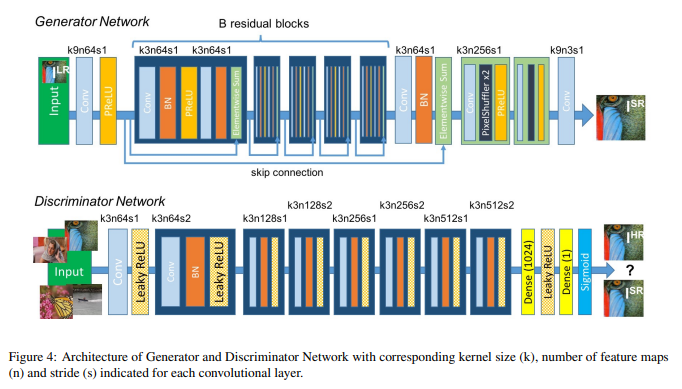

In [15]:
# Now we got to make the Generator Loss
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size
  
  
  @staticmethod # Must add this
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

In [16]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    vgg = vgg16(pretrained=True)
    loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
    for param in loss_network.parameters():
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()
    self.tv_loss = TVLoss()
  def forward(self, out_labels, out_images, target_images):
    adversial_loss = torch.mean(1 - out_labels)
    perception_loss = self.mse_loss(out_images, target_images)
    image_loss = self.mse_loss(out_images, target_images)
    tv_loss = self.tv_loss(out_images)
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


In [17]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standard device selectoin
device

device(type='cuda')

In [18]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [19]:
generator_criterion = GeneratorLoss()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [20]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [21]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [22]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

In [23]:
## Now for training code
from tqdm import tqdm
import os

In [24]:
N_EPOCHS = 150 # 150 is good enough for our model. gives decent enough results

In [ ]:
for epoch in range(1, N_EPOCHS + 1):
  train_bar = tqdm(trainloader)
  running_results = {'batch_sizes':0, 'd_loss':0,
                     "g_loss":0, "d_score":0, "g_score":0}

  netG.train()
  netD.train()
  for data, target in train_bar:
    g_update_first = True
    batch_size = data.size(0)
    running_results['batch_sizes'] += batch_size

    real_img = Variable(target)
    real_img = real_img.to(device)
    z = Variable(data)
    z = z.to(device)

    ## Update Discriminator ##
    fake_img = netG(z)
    netD.zero_grad()
    real_out = netD(real_img).mean()
    fake_out = netD(fake_img).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph = True)
    optimizerD.step()
    
    ## Now update Generator
    fake_img = netG(z)
    fake_out = netD(fake_img).mean()
    netG.zero_grad()
    g_loss = generator_criterion(fake_out, fake_img, real_img)
    g_loss.backward()

    fake_img = netG(z)
    fake_out = netD(fake_img).mean()

    optimizerG.step()

    running_results['g_loss'] += g_loss.item() * batch_size
    running_results['d_loss'] += d_loss.item() * batch_size
    running_results['d_score'] += real_out.item() * batch_size
    running_results['g_score'] += real_out.item() * batch_size

    ## Updating the progress bar
    train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
        epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
        running_results['g_loss'] / running_results['batch_sizes'],
        running_results['d_score'] / running_results['batch_sizes'],
        running_results['g_score'] / running_results['batch_sizes']
    ))
  netG.eval()

  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
[1/150] Loss_D: 0.8464 Loss_G: 0.0421 D(x): 0.5814 D(G(z)): 0.5814: 100%|██████████| 13/13 [01:19<00:00,  6.08s/it]
[2/150] Loss_D: 0.5984 Loss_G: 0.0178 D(x): 0.6874 D(G(z)): 0.6874: 100%|██████████| 13/13 [01:15<00:00,  5.83s/it]
[3/150] Loss_D: 0.3737 Loss_G: 0.0143 D(x): 0.8043 D(G(z)): 0.8043: 100%|██████████| 13/13 [01:15<00:00,  5.82s/it]
[4/150] Loss_D: 0.2709 Loss_G: 0.0124 D(x): 0.8584 D(G(z)): 0.8584: 100%|██████████| 13/13 [01:14<00:00,  5.73s/it]
[5/150] Loss_D: 0.1804 Loss_G: 0.0118 D(x)